<a href="https://colab.research.google.com/github/jainriya9/DeepFake-Detection/blob/main/Tackling_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/Celeb-DF'))

['List_of_testing_videos.txt', 'Celeb-synthesis', 'Celeb-real', 'YouTube-real', 'Frames-Real', 'Frames-Fake', 'Frames-Real-20240626T130257Z-001.zip', 'Frames-Fake-20240626T130258Z-001.zip', 'Frames-YouTube-real', 'model.h5']


In [ ]:
# Define the paths to your dataset in Google Drive
real_videos_dir = '/content/drive/MyDrive/Celeb-DF/Celeb-real'
fake_videos_dir = '/content/drive/MyDrive/Celeb-DF/Celeb-synthesis'

# Verify that the paths are correct
import os
print(os.listdir(real_videos_dir))
print(os.listdir(fake_videos_dir))

['id0_0000.mp4', 'id0_0001.mp4', 'id0_0002.mp4', 'id0_0005.mp4', 'id0_0006.mp4', 'id10_0000.mp4', 'id0_0009.mp4', 'id0_0003.mp4', 'id0_0008.mp4', 'id0_0007.mp4', 'id0_0004.mp4', 'id11_0005.mp4', 'id10_0001.mp4', 'id10_0006.mp4', 'id11_0006.mp4', 'id10_0002.mp4', 'id10_0008.mp4', 'id10_0007.mp4', 'id10_0003.mp4', 'id10_0009.mp4', 'id10_0005.mp4', 'id11_0003.mp4', 'id11_0002.mp4', 'id11_0000.mp4', 'id11_0001.mp4', 'id10_0004.mp4', 'id11_0004.mp4', 'id12_0004.mp4', 'id13_0005.mp4', 'id13_0008.mp4', 'id13_0000.mp4', 'id11_0008.mp4', 'id13_0007.mp4', 'id13_0009.mp4', 'id13_0006.mp4', 'id11_0010.mp4', 'id12_0000.mp4', 'id12_0001.mp4', 'id13_0004.mp4', 'id11_0009.mp4', 'id13_0001.mp4', 'id12_0003.mp4', 'id11_0007.mp4', 'id12_0006.mp4', 'id13_0003.mp4', 'id12_0005.mp4', 'id13_0002.mp4', 'id12_0002.mp4', 'id13_0015.mp4', 'id13_0014.mp4', 'id16_0003.mp4', 'id13_0013.mp4', 'id13_0010.mp4', 'id16_0000.mp4', 'id13_0012.mp4', 'id16_0001.mp4', 'id16_0002.mp4', 'id13_0011.mp4', 'id17_0006.mp4', 'id16_

In [ ]:
import os
import cv2

def extract_frames(video_path, output_folder, frame_interval=25):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(0, frame_count, frame_interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame_filename = os.path.join(output_folder, f"{os.path.basename(video_path).split('.')[0]}_frame_{i}.jpg")
            cv2.imwrite(frame_filename, frame)
    cap.release()

# Paths to datasets
real_videos_dir = '/content/drive/MyDrive/Celeb-DF/Celeb-real'
fake_videos_dir = '/content/drive/MyDrive/Celeb-DF/Celeb-synthesis'

# Output paths for frames
real_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real'
fake_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake'

# Extract frames from real videos
for video_file in os.listdir(real_videos_dir):
    video_path = os.path.join(real_videos_dir, video_file)
    extract_frames(video_path, real_frames_path)

# Extract frames from fake videos
for video_file in os.listdir(fake_videos_dir):
    video_path = os.path.join(fake_videos_dir, video_file)
    extract_frames(video_path, fake_frames_path)

print(f"Extracted frames saved to {real_frames_path} and {fake_frames_path}.")

Extracted frames saved to /content/drive/MyDrive/Celeb-DF/Frames-Real and /content/drive/MyDrive/Celeb-DF/Frames-Fake.


In [ ]:
# Output paths for frames
real_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real'
fake_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2

# Define minimal data augmentation for real frames
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

# Augment frames without saving
def augment_frames(image_folder):
    augmented_frames = []
    for filename in os.listdir(image_folder):
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = image.reshape((1,) + image.shape)  # Reshape for datagen
        augmented_iter = datagen.flow(image, batch_size=1)
        augmented_frames.append(next(augmented_iter)[0].astype(np.uint8))  # Take one augmented frame
    return augmented_frames

# Augment real frames only
augmented_real_frames = augment_frames(real_frames_path)

# Display the number of augmented frames
print(f"Augmented {len(augmented_real_frames)} real frames.")

Augmented 2538 real frames.


In [ ]:
import librosa
import numpy as np
from scipy.fftpack import fft
from scipy.signal import butter, lfilter

def extract_mfcc_fft(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    signal = image_gray.mean(axis=0)

    # High-pass filter
    cutoff_freq = 100  # Adjust this value based on your desired cutoff frequency
    nyquist_freq = 0.5 * 22050
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(4, normal_cutoff, btype='high', analog=False)
    filtered_signal = lfilter(b, a, signal)

    # Adjust n_fft based on the length of filtered_signal
    n_fft = min(2048, len(filtered_signal))  # Set n_fft to be smaller of 2048 or signal length
    mfccs = librosa.feature.mfcc(y=filtered_signal, sr=22050, n_mfcc=13, n_fft=n_fft)
    fft_features = np.abs(fft(filtered_signal, n=n_fft))
    return mfccs, fft_features

# Example usage
# real_features = [extract_mfcc_fft(frame) for frame in augmented_real_frames]
# fake_features = [extract_mfcc_fft(frame) for frame in fake_frames]

# Ensure to handle varying signal lengths appropriately in your actual application.


# Extract features from augmented real frames
real_features = [extract_mfcc_fft(frame) for frame in augmented_real_frames]

# Extract features from fake frames (not augmented)
fake_features = []
for filename in os.listdir(fake_frames_path):
    image_path = os.path.join(fake_frames_path, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mfcc, fft_features = extract_mfcc_fft(image)
    fake_features.append((mfcc, fft_features))

print(f"Extracted features from {len(real_features)} augmented real frames.")
print(f"Extracted features from {len(fake_features)} fake frames.")


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Extracted features from 2538 augmented real frames.
Extracted features from 12888 fake frames.


In [ ]:
import numpy as np

# Assuming you have extracted features stored in real_features and fake_features
# real_features and fake_features should be lists of tuples (mfccs, fft_features)

# Pad or truncate MFCC features to a consistent length
max_length = max(len(f[0][0]) for f in real_features + fake_features)  # Find the maximum length
X_mfcc = []
for f in real_features + fake_features:
    mfcc = f[0]
    if len(mfcc[0]) < max_length:
        # Pad with zeros along the time axis
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - len(mfcc[0]))), mode='constant')
    elif len(mfcc[0]) > max_length:
        # Truncate along the time axis
        mfcc = mfcc[:, :max_length]
    X_mfcc.append(mfcc)

X_mfcc = np.array(X_mfcc)

# Pad or truncate FFT features to a consistent length
max_length_fft = max(len(f[1]) for f in real_features + fake_features)
X_fft = []
for f in real_features + fake_features:
    fft_features = f[1]
    if len(fft_features) < max_length_fft:
        # Pad with zeros
        fft_features = np.pad(fft_features, (0, max_length_fft - len(fft_features)), mode='constant')
    elif len(fft_features) > max_length_fft:
        # Truncate
        fft_features = fft_features[:max_length_fft]
    X_fft.append(fft_features)

X_fft = np.array(X_fft)

# Create labels: 0 for real, 1 for fake
y_labels = np.array([0] * len(real_features) + [1] * len(fake_features))


In [ ]:
print("MFCCs shape:", mfcc.shape)
print("FFT features shape:", fft_features.shape)

MFCCs shape: (13, 2)
FFT features shape: (974,)


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, LayerNormalization, Add
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

# Assuming X_mfcc, X_fft, and y_labels are already defined as in the previous step

# --- Input Layers ---
# For MFCC features
mfcc_input = Input(shape=X_mfcc[0].shape)

# For FFT features
fft_input = Input(shape=(X_fft[0].shape))

# --- Dense Layers for MFCC ---
# Use Dense layers instead of Embedding for continuous MFCC features
mfcc_dense1 = Dense(128, activation='relu')(mfcc_input)
mfcc_dense2 = Dense(64, activation='relu')(mfcc_dense1)
mfcc_flat = Flatten()(mfcc_dense2)

# --- Dense Layer for FFT ---
fft_embedding = Dense(64, activation='relu')(fft_input)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print("MFCC input:", mfcc_input.shape)
print("fft input:", fft_input.shape)


MFCC input: (None, 13, 2)
fft input: (None, 974)


In [ ]:
def pvt_block(x, num_channels):
    # A simplified PVT block (adapt as needed)
    shortcut = x
    x = Conv2D(num_channels, kernel_size=1, strides=1, padding='same')(x)
    x = LayerNormalization()(x)
    x = tf.nn.relu(x)
    x = Conv2D(num_channels, kernel_size=3, strides=1, padding='same')(x)
    x = LayerNormalization()(x)
    x = tf.nn.relu(x)  # Continue the block here
    # Project the shortcut to match the number of channels
    shortcut = Conv2D(num_channels * 4, kernel_size=1, strides=1, padding='same')(shortcut)
    x = Conv2D(num_channels * 4, kernel_size=1, strides=1, padding='same')(x)
    x = LayerNormalization()(x)
    x = Add()([shortcut, x])
    x = tf.nn.relu(x)
    return x

here

In [ ]:
from tensorflow.keras.layers import Reshape
reshaped_fft_embedding = Reshape((8, 8, 1))(fft_embedding)

# Pass the reshaped output to pvt_block
pvt_output = pvt_block(reshaped_fft_embedding, 64)

In [ ]:
# --- Concatenate Embeddings and PVT Output ---
# Flatten pvt_output to match the shape of mfcc_flat and fft_embedding
pvt_flat = Flatten()(pvt_output)
concat = Concatenate()([mfcc_flat, fft_embedding, pvt_flat])

# --- Multimodal and Distillation Heads ---
multimodal_head = Dense(2, activation='softmax', name='multimodal_head')(concat) # Adjust num_classes
distillation_head = Dense(2, activation='softmax', name='distillation_head')(pvt_flat) # Adjust num_classes, use pvt_flat here

# --- Create the Model ---
model = Model(inputs=[mfcc_input, fft_input], outputs=[multimodal_head, distillation_head])

# --- Compile the Model ---
model.compile(
    optimizer='adam',
    loss={
        'multimodal_head': 'categorical_crossentropy',
        'distillation_head': 'categorical_crossentropy'
    },
    metrics=['accuracy'],
    run_eagerly=True
)
# --- Print Model Summary ---
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 974)]                0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 64)                   62400     ['input_2[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 8, 8, 1)              0         ['dense_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 64)             128       ['reshape[0][0]']             
                                                                                              

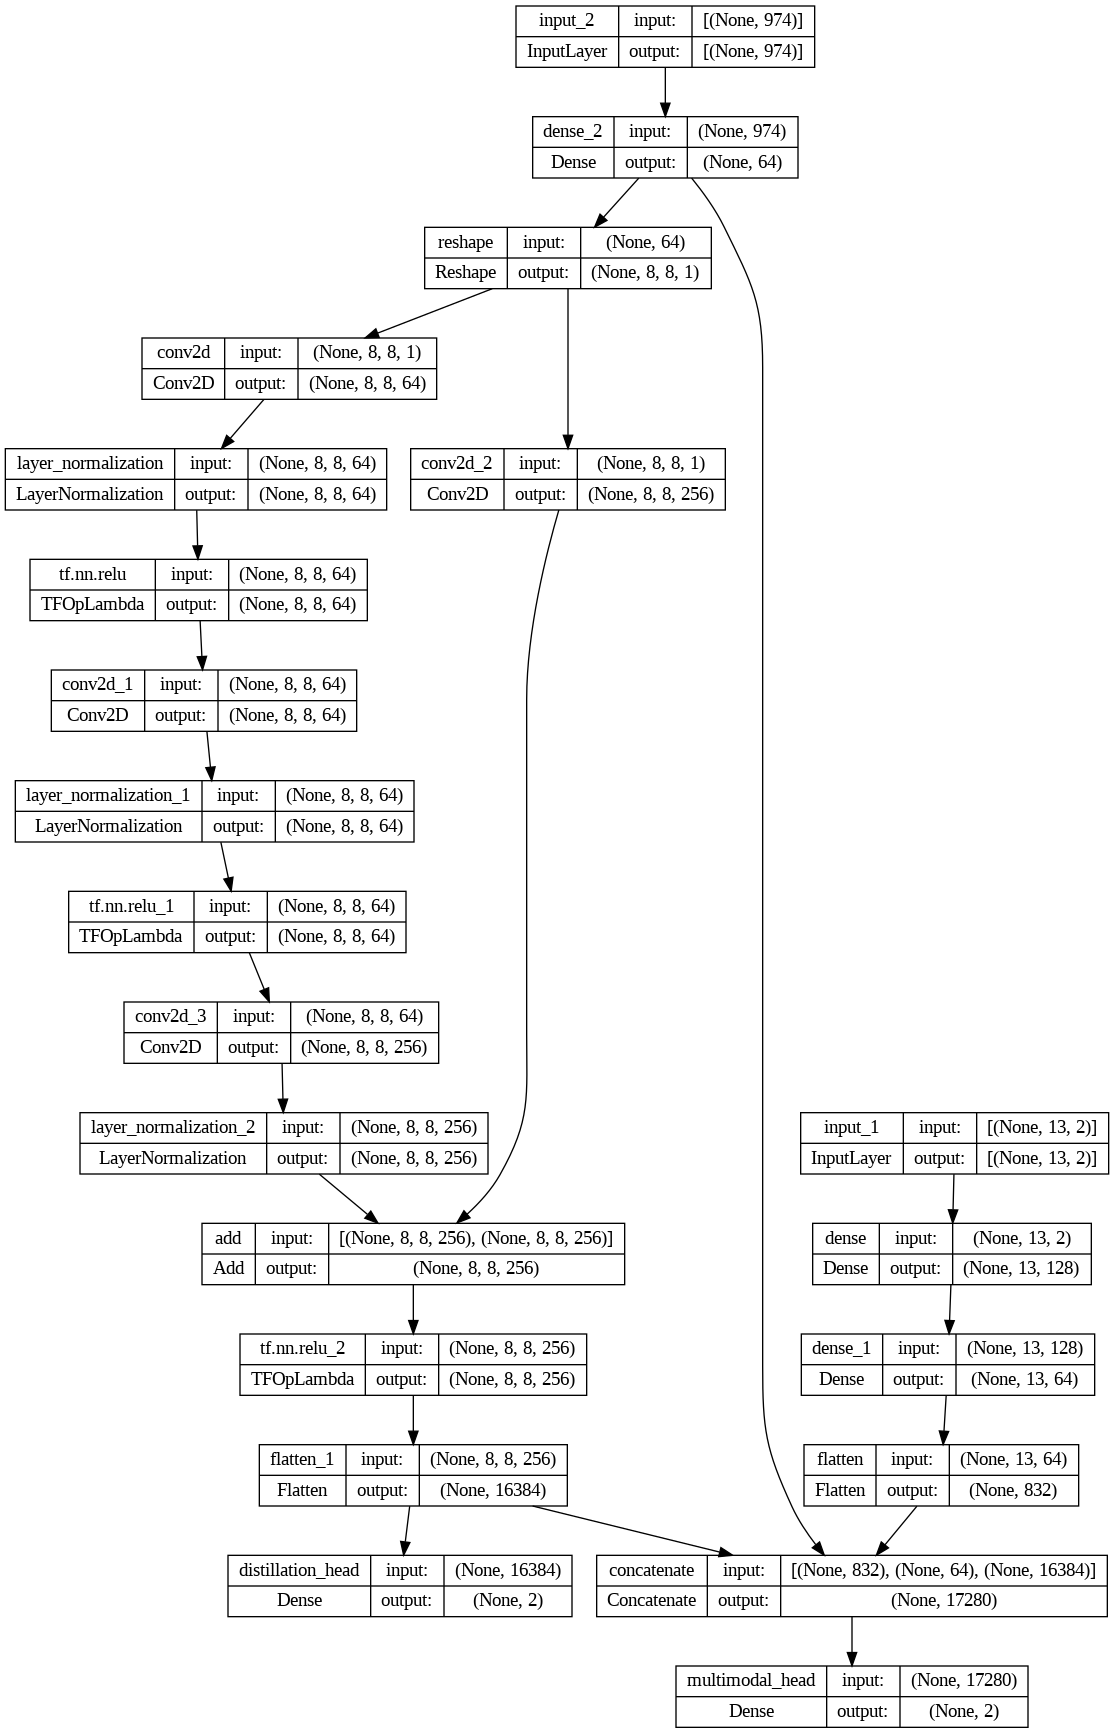

In [ ]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
# Print model graph
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (adjust test_size as needed)
X_mfcc_train, X_mfcc_val, X_fft_train, X_fft_val, y_train, y_val = train_test_split(
    X_mfcc, X_fft, y_labels, test_size=0.2, random_state=42
)

In [ ]:
# Print shapes before model compilation
print("Shapes before model compilation:")
print("X_mfcc_train shape:", X_mfcc_train.shape)
print("X_fft_train shape:", X_fft_train.shape)
print("y_train shape:", y_train.shape)

Shapes before model compilation:
X_mfcc_train shape: (12340, 13, 2)
X_fft_train shape: (12340, 974)
y_train shape: (12340,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels (if they are not already)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)


In [ ]:
history = model.fit(
    x=[X_mfcc_train, X_fft_train],  # Provide training data for MFCC and FFT inputs
    y={'multimodal_head': y_train, 'distillation_head': y_train},  # Assuming both heads use the same labels
    epochs=2,  # Adjust the number of epochs as needed
    batch_size=8,  # Adjust the batch size as needed
    validation_data=([X_mfcc_val, X_fft_val],
                     {'multimodal_head': y_val, 'distillation_head': y_val})  # Use validation data
)

Epoch 1/2


1543/1543 [==============================] - 136s 85ms/step - loss: 1.8949 - multimodal_head_loss: 0.9580 - distillation_head_loss: 0.9369 - multimodal_head_accuracy: 0.8916 - distillation_head_accuracy: 0.8708 - val_loss: 0.5660 - val_multimodal_head_loss: 0.2351 - val_distillation_head_loss: 0.3309 - val_multimodal_head_accuracy: 0.9397 - val_distillation_head_accuracy: 0.8992
Epoch 2/2
1543/1543 [==============================] - 129s 83ms/step - loss: 0.6005 - multimodal_head_loss: 0.2637 - distillation_head_loss: 0.3368 - multimodal_head_accuracy: 0.9149 - distillation_head_accuracy: 0.8936 - val_loss: 0.4608 - val_multimodal_head_loss: 0.1865 - val_distillation_head_loss: 0.2743 - val_multimodal_head_accuracy: 0.9391 - val_distillation_head_accuracy: 0.9174


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, LayerNormalization, Add, Reshape
from tensorflow.keras.models import Model

# --- Input Layers ---
mfcc_input = Input(shape=X_mfcc[0].shape)
fft_input = Input(shape=(X_fft[0].shape))

# --- MFCC and FFT Branches ---
# ... (Your existing code for MFCC and FFT branches) ...

# --- Multimodal and Distillation Heads ---
multimodal_head = Dense(2, activation='softmax', name='multimodal_head')(concat)
distillation_head = Dense(2, activation='softmax', name='distillation_head')(pvt_flat)

#Concatenate the outputs of the heads
concatenated_heads = Concatenate()([multimodal_head, distillation_head])


In [ ]:
# --- Custom Dense Embedding Layer ---
embedding_dim = 32  # Adjust this based on your needs
embedding_layer = Dense(embedding_dim, activation='relu', name='embedding_layer')(concatenated_heads)

# --- Reshape for ViT input (adjust dimensions as needed) ---
vit_input_reshaped = Reshape((4, 8))(embedding_layer)


In [ ]:
from tensorflow.keras import layers

class PVTBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(PVTBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)  # Output dimension should match embed_dim
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        # Add a projection layer to match the embedding dimension
        self.projection = layers.Dense(embed_dim)

    def call(self, inputs):
        # Project the input to match the embedding dimension
        projected_inputs = self.projection(inputs)
        attn_output = self.att(projected_inputs, projected_inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(projected_inputs + attn_output)  # Use projected_inputs here
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)  # Now shapes should match

In [ ]:
# --- Input Layers ---
mfcc_input = Input(shape=(13, 130))
fft_input = Input(shape=(130,))

# --- MFCC and FFT Branches ---
mfcc_flatten = Flatten()(mfcc_input)
fft_flatten = Flatten()(fft_input)

concat = Concatenate()([mfcc_flatten, fft_flatten])
embedded = Dense(256, activation='relu')(concat)

# --- Multimodal and Distillation Heads ---
multimodal_head = Dense(2, activation='softmax', name='multimodal_head')(embedded)
distillation_head = Dense(2, activation='softmax', name='distillation_head')(embedded)

# Concatenate the outputs of the heads
concatenated_heads = Concatenate()([multimodal_head, distillation_head])

# --- Custom Dense Embedding Layer ---
embedding_dim = 32  # Adjust this based on your needs
embedding_layer = Dense(embedding_dim, activation='relu', name='embedding_layer')(concatenated_heads)

# Reshape embedding layer to match PVT block input requirements
embedding_layer_reshaped = Reshape((embedding_dim, 1))(embedding_layer)  # Adjust this as needed

In [ ]:
def patch_embedding_layer(input_tensor, patch_size, embed_dim):
    patches = tf.image.extract_patches(
        images=input_tensor,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    n_p = tf.shape(patches)[1]
    # Reshape patches
    patches = tf.reshape(patches, (-1, n_p * n_p * patch_size * patch_size * tf.shape(input_tensor)[-1]))
    return Dense(embed_dim)(patches)
t1=tf.ones(shape=(8,128,128,3))
q=Input(shape=(128,128,3))
m=Model(q,patch_embedding_layer(q,16,32))
m


In [ ]:
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.image.extract_patches (  (None, 8, 8, 768)            0         ['input_7[0][0]']             
 TFOpLambda)                                                                                      
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (4,)                         0         ['tf.image.extract_patches[0][
 mbda)                                                              0]']                          
                                                                                            

In [ ]:

from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Concatenate, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def patch_embedding_layer(input_shape, patch_size, embed_dim):
    patches = tf.image.extract_patches(
        images=input_shape,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    input_shape_val = tf.shape(input_shape)
    patches = tf.reshape(patches, (-1, patch_size * patch_size * input_shape_val[-1]))
    return Dense(embed_dim)(patches)

vit_input = Input(shape=(128, 128, 3))
patch_size = 16  # Example patch size
embed_dim = 32  # Example embedding dimension
patches = patch_embedding_layer(vit_input, patch_size=patch_size, embed_dim=embed_dim)

num_patches = (tf.shape(vit_input)[1] // patch_size) * (tf.shape(vit_input)[2] // patch_size)
patches = Lambda(lambda x: tf.reshape(x, (-1, tf.cast(tf.shape(x)[0] // embed_dim, tf.int32), embed_dim)))(patches)


# Apply PVT Blocks
x = PVTBlock(embed_dim=embed_dim, num_heads=4, ff_dim=128)(patches)
x = PVTBlock(embed_dim=embed_dim, num_heads=4, ff_dim=128)(x)

# Add Transformer Encoder layers
def transformer_encoder(x, num_heads, ff_dim):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = Add()([x, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ffn_output = Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    x = Add()([attn_output, ffn_output])
    return LayerNormalization()(x)

# Apply transformer encoders
num_transformer_layers = 2
for _ in range(num_transformer_layers):
    print(x)
    x = transformer_encoder(x, num_heads=4, ff_dim=128)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Combine with another embedding layer if needed
embedding_layer = Dense(128)(x)  # Example embedding layer

# Final classification head
output = Dense(2, activation='softmax', name='final_output')(embedding_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, None, 32), dtype=tf.float32, name=None), name='pvt_block_1/layer_normalization_6/batchnorm/add_1:0', description="created by layer 'pvt_block_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, 32), dtype=tf.float32, name=None), name='layer_normalization_8/add:0', description="created by layer 'layer_normalization_8'")


In [ ]:
model = Model(inputs=[mfcc_input, fft_input, vit_input], outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.shape_2 (TFOp  (4,)                         0         ['input_8[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.getitem_2  ()                           0         ['tf.compat.v1.shape_2[0][0]']
  (SlicingOpLambda)                                                                               
                                                                                            

In [ ]:
# Define the final model
model = Model(inputs=[mfcc_input, fft_input, vit_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.shape_2 (TFOp  (4,)                         0         ['input_8[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.getitem_2  ()                           0         ['tf.compat.v1.shape_2[0][0]']
  (SlicingOpLambda)                                                                               
                                                                                            

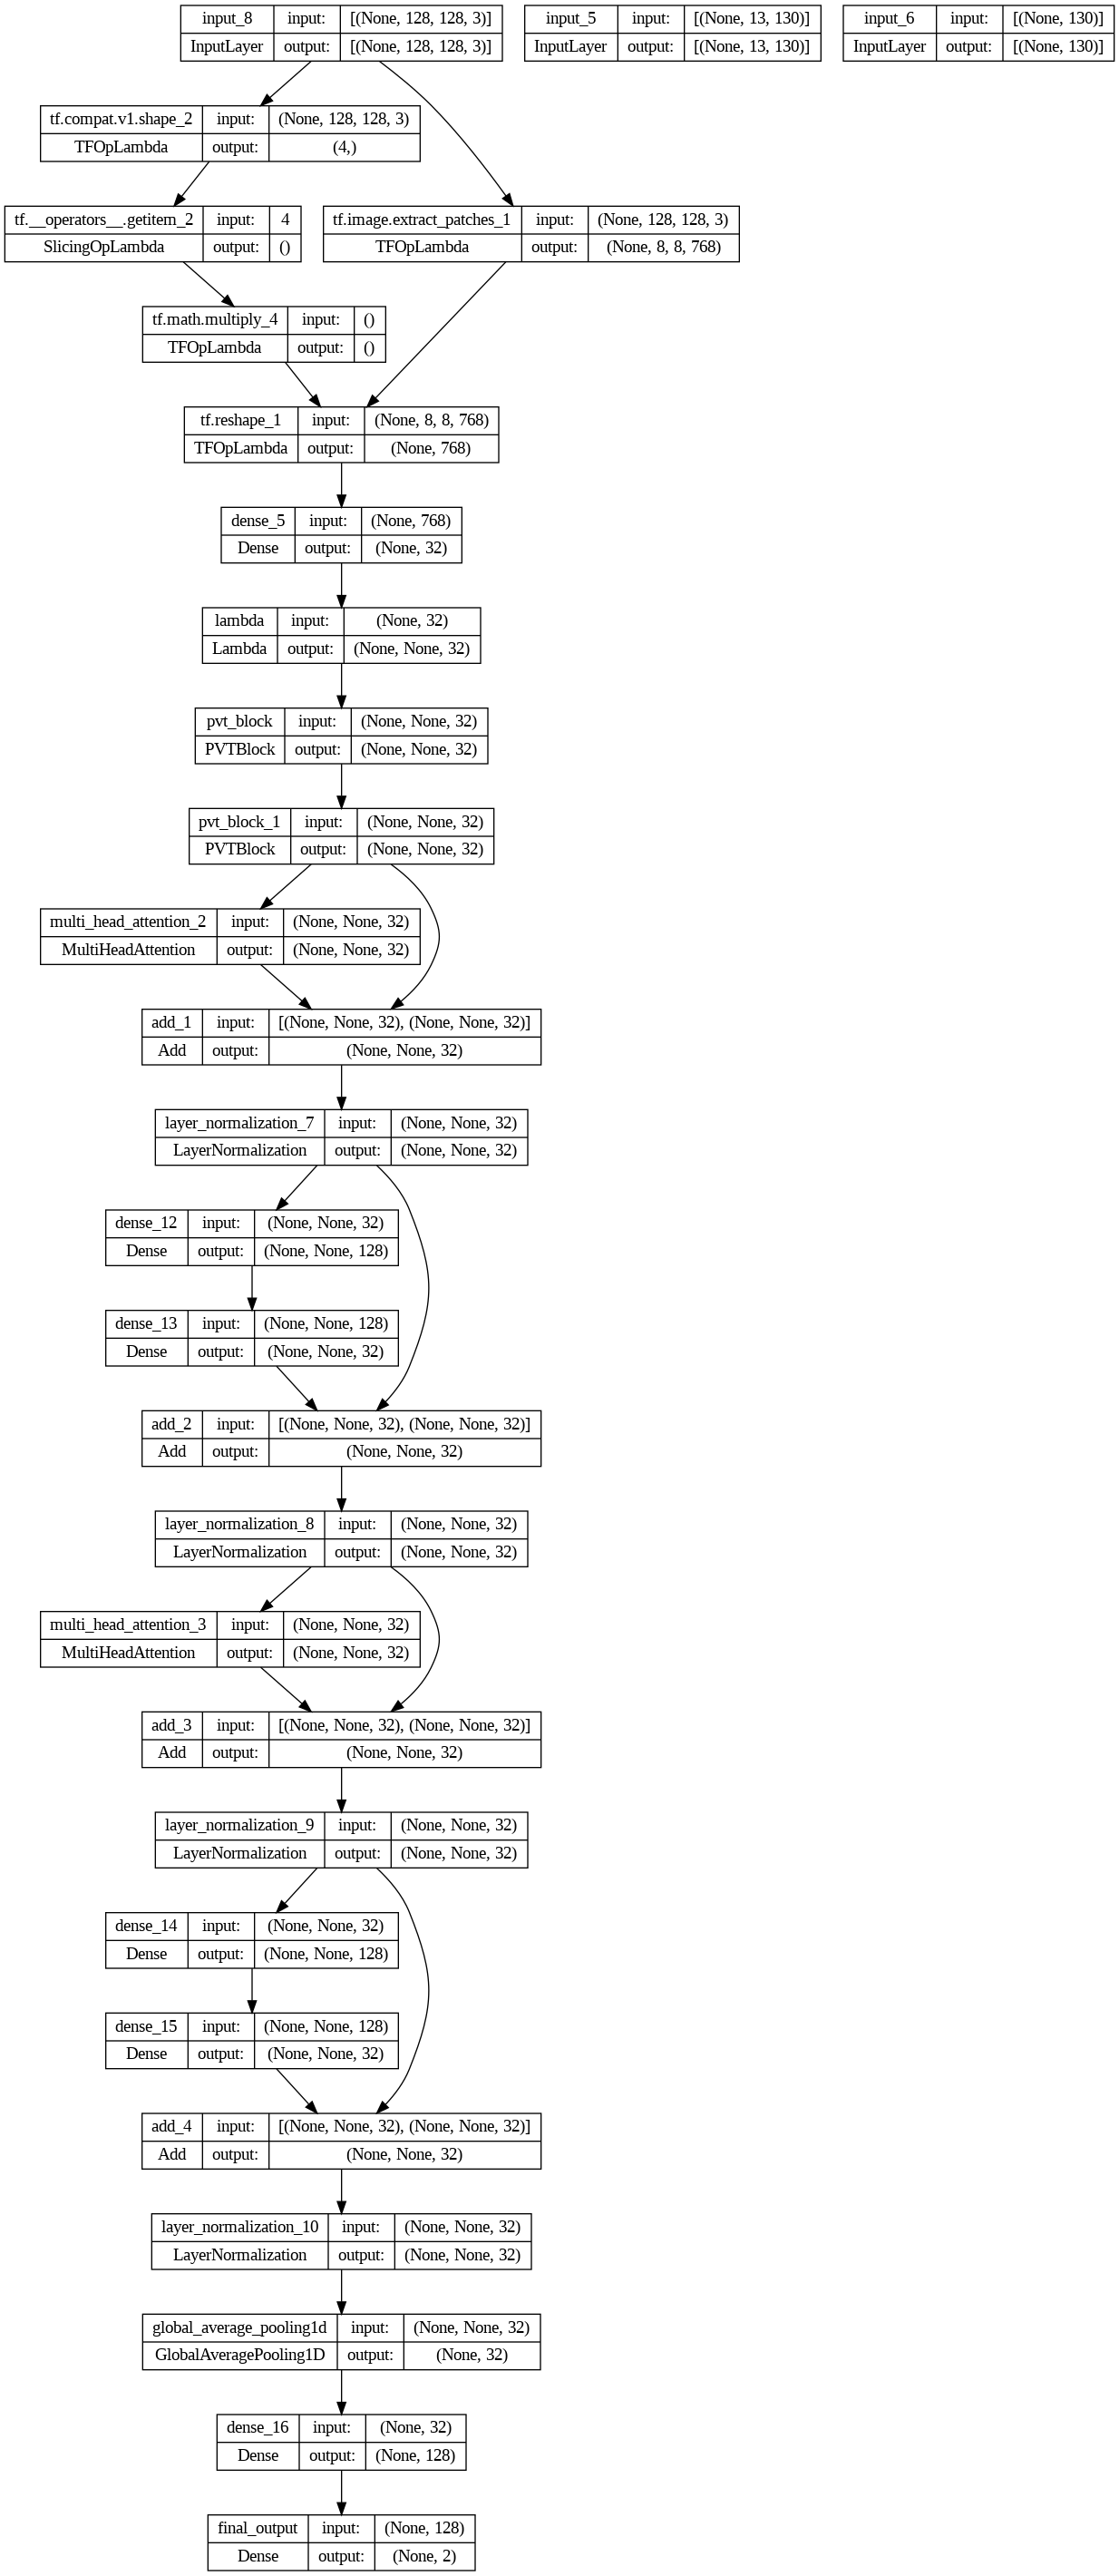

In [ ]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
# Print model graph
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# import os
# import cv2
# import numpy as np
# from scipy.fftpack import fft
# from scipy.signal import butter, lfilter
# import librosa
# import zipfile

# # Function to extract MFCC and FFT features from an image
# def extract_mfcc_fft(image):
#     # Example: feature extraction logic
#     image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     signal = image_gray.mean(axis=0)

#     # Example: high-pass filter
#     cutoff_freq = 100
#     nyquist_freq = 0.5 * 22050
#     normal_cutoff = cutoff_freq / nyquist_freq
#     b, a = butter(4, normal_cutoff, btype='high', analog=False)
#     filtered_signal = lfilter(b, a, signal)

#     n_fft = min(2048, len(filtered_signal))
#     mfccs = librosa.feature.mfcc(y=filtered_signal, sr=22050, n_mfcc=13, n_fft=n_fft)
#     fft_features = np.abs(fft(filtered_signal, n=n_fft))

#     return mfccs, fft_features, image

# # Function to save features to zip
# def save_features_to_zip(features, zip_filename):
#     with zipfile.ZipFile(zip_filename, 'w') as zipf:
#         for idx, (mfcc, fft, image) in enumerate(features):
#             # Define filenames for each feature and image
#             mfcc_filename = f'{idx}_mfcc.npy'
#             fft_filename = f'{idx}_fft.npy'
#             image_filename = f'{idx}_image.jpg'

#             # Save MFCC, FFT, and image to zip file
#             np.save(zipf, mfcc_filename, mfcc)
#             np.save(zipf, fft_filename, fft)
#             cv2.imwrite(image_filename, image)

# # Step 1: Define paths to your zip files
# real_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real-20240626T130257Z-001.zip'
# fake_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake-20240626T130258Z-001.zip'

# # Step 2: Unzip the files
# real_extract_path = '/content/Frames-Real'
# fake_extract_path = '/content/Frames-Fake'

# !unzip -q -o '{real_zip_path}' -d '{real_extract_path}'
# !unzip -q -o '{fake_zip_path}' -d '{fake_extract_path}'

# # Function to process images from a directory and extract features
# def process_images_and_extract_features(image_dir):
#     features = []
#     for subdir, dirs, files in os.walk(image_dir):
#         for filename in files:
#             image_path = os.path.join(subdir, filename)
#             try:
#                 image = cv2.imread(image_path)
#                 if image is None:
#                     print(f"Error reading image: {image_path}")
#                     continue

#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#                 mfcc, fft, processed_image = extract_mfcc_fft(image)
#                 features.append((mfcc, fft, processed_image))

#             except Exception as e:
#                 print(f"Error processing image: {image_path}, Error: {str(e)}")
#                 continue

#     return features

# # Process real images
# real_features = process_images_and_extract_features(real_extract_path)

# # Process fake images
# fake_features = process_images_and_extract_features(fake_extract_path)

# # Step 3: Save extracted features to zip files
# real_zip_filename = '/content/drive/MyDrive/Celeb-DF/Real_Extracted_Features.zip'
# fake_zip_filename = '/content/drive/MyDrive/Celeb-DF/Fake_Extracted_Features.zip'

# save_features_to_zip(real_features, real_zip_filename)
# save_features_to_zip(fake_features, fake_zip_filename)

# print(f"Real features saved to '{real_zip_filename}'")
# print(f"Fake features saved to '{fake_zip_filename}'")


In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define paths to your zip files
real_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real-20240626T130257Z-001.zip'
fake_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake-20240626T130258Z-001.zip'

# Unzip the files
!unzip -q -o '{real_zip_path}' -d '/content/Frames-Real'
!unzip -q -o '{fake_zip_path}' -d '/content/Frames-Fake'

# --- Data Generators ---
datagen = ImageDataGenerator(rescale=1./255)

# Define batch size for generators
batch_size = 16

real_generator = datagen.flow_from_directory(
    directory='/content/Frames-Real',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

fake_generator = datagen.flow_from_directory(
    directory='/content/Frames-Fake',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

def combined_generator(real_gen, fake_gen):
    while True:
        # Get batches from both generators simultaneously
        real_data, real_labels = next(real_gen)
        fake_data, fake_labels = next(fake_gen)

        # Combine batches
        combined_images = np.concatenate((real_data, fake_data), axis=0)
        combined_labels = np.concatenate((real_labels, fake_labels), axis=0)

        # Shuffle combined batch
        combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)

        # Generate dummy data for MFCC and FFT (replace with actual data)
        batch_size = combined_images.shape[0]
        mfcc_data = np.zeros((batch_size, 13, 130))  # Dummy MFCC data
        fft_data = np.zeros((batch_size, 130))       # Dummy FFT data

        # Convert labels to one-hot encoding
        combined_labels = tf.keras.utils.to_categorical(combined_labels, num_classes=2)

        yield [mfcc_data, fft_data, combined_images], combined_labels

# Combined generator
combined_gen = combined_generator(real_generator, fake_generator)


Found 2538 images belonging to 1 classes.
Found 12888 images belonging to 1 classes.


In [ ]:
def check_batch_sizes(generator):
    for inputs, labels in generator:
        batch_size = len(inputs)  # Assuming inputs is a list or array
        return batch_size

# Check batch sizes after adjustment
batch_size_combined_gen = check_batch_sizes(combined_gen)
batch_size_fake_gen = check_batch_sizes(fake_generator)

print(f"Batch size of combined_gen: {batch_size_combined_gen}")
print(f"Batch size of fake_generator: {batch_size_fake_gen}")


Batch size of combined_gen: 3
Batch size of fake_generator: 16


In [ ]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)

        # Ensure both labels and predictions are float32
        labels = tf.cast(labels, tf.float32)
        predictions = tf.cast(predictions, tf.float32)

        # Print shapes and types for debugging
        print("Labels shape:", labels.shape)
        print("Predictions shape:", predictions.shape)
        print("Labels dtype:", labels.dtype)
        print("Predictions dtype:", predictions.dtype)

        # Compute categorical crossentropy loss
        loss = tf.keras.losses.categorical_crossentropy(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Function to print the shapes of inputs and labels from the generator
def print_generator_shapes(generator, name):
    for inputs, labels in generator:
        if isinstance(inputs, list):
            print(f"Shapes of {name} inputs:")
            for i, input_tensor in enumerate(inputs):
                print(f"  Input {i+1} shape: {input_tensor.shape}")
        else:
            print(f"Shape of {name} inputs:", inputs.shape)

        if isinstance(labels, list):
            print(f"Shapes of {name} labels:")
            for i, label_tensor in enumerate(labels):
                print(f"  Label {i+1} shape: {label_tensor.shape}")
        else:
            print(f"Shape of {name} labels:", labels.shape)
        break  # Print the shapes for the first batch only

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()  # Or any other optimizer you prefer

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set the number of epochs per batch
epochs_per_batch = 2  # Number of epochs to run in each batch
total_epochs = 4   # Total number of epochs to train the model

# Define checkpoint callback to save the model weights
checkpoint_cb = ModelCheckpoint('model_checkpoint.h5', save_best_only=True, save_weights_only=True)

# Load weights if continuing training from a checkpoint
try:
    model.load_weights('model_checkpoint.h5')
    print("Checkpoint loaded. Continuing training from last saved epoch.")
except Exception as e:
    print("No checkpoint found. Starting training from scratch.")

# Print the shapes of the inputs and labels to check for any mismatches
print_generator_shapes(combined_gen, "training")
print_generator_shapes(combined_gen, "validation")

# Train the model in smaller batches
current_epoch = 0
while current_epoch < total_epochs:
    print(f"Training epochs {current_epoch+1} to {current_epoch+epochs_per_batch}...")

    for inputs, labels in combined_gen:
        # Ensure labels are in the correct shape
        labels = tf.cast(labels, tf.float32)

        # Compute loss and update gradients
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            # Match the batch size of labels and predictions
            loss = tf.keras.losses.categorical_crossentropy(labels[:predictions.shape[0]], predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Print loss or other metrics as needed
        print(f"Loss: {tf.reduce_mean(loss).numpy()}")

        # Break the loop after one batch (epochs_per_batch should handle epoch count)
        break

    # Increment the current epoch counter
    current_epoch += epochs_per_batch

    # Save the model weights after each batch of epochs
    model.save_weights(f'model_weights_epoch_{current_epoch}.h5')
    print(f"Model weights saved for epoch {current_epoch}.")

print("Training complete.")


No checkpoint found. Starting training from scratch.
Shapes of training inputs:
  Input 1 shape: (32, 13, 130)
  Input 2 shape: (32, 130)
  Input 3 shape: (32, 128, 128, 3)
Shape of training labels: (32, 2)
Shapes of validation inputs:
  Input 1 shape: (32, 13, 130)
  Input 2 shape: (32, 130)
  Input 3 shape: (32, 128, 128, 3)
Shape of validation labels: (32, 2)
Training epochs 1 to 2...
Loss: 0.8189377784729004
Model weights saved for epoch 2.
Training epochs 3 to 4...
Loss: 0.030163981020450592
Model weights saved for epoch 4.
Training complete.


In [ ]:
# # Example convolutional layers
# # conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(vit_input)
# # conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(conv1)
# # conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(conv2)

# # Example convolutional layers with L2 regularization (for overfitting)
# from tensorflow.keras.regularizers import l2
# conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(vit_input)
# conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(conv1)
# conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(conv2)


# # Apply Global Average Pooling
# gap = tf.keras.layers.GlobalAveragePooling2D()(conv3)

# # Example dense layers
# #dense1 = tf.keras.layers.Dense(256, activation='relu')(gap)      #previous
# dense1 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(gap)    #new added
# #dense1 = Dropout(0.1)(dense1)  # Adding Dropout                     #new added
# dense2 = tf.keras.layers.Dense(2, activation='softmax', name='output')(dense1)
# #dense2 = Dropout(0.1)(dense2)  # Adding Dropout                      #new added

# # Define the model with inputs and outputs
# model = tf.keras.models.Model(inputs=[mfcc_input, fft_input, vit_input], outputs=dense2)

# #new added
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Example convolutional layers with modifications
conv1 = Conv2D(32, (3, 3), kernel_initializer='he_normal')(vit_input)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.1)(conv1)

conv2 = Conv2D(64, (3, 3), kernel_initializer='he_normal')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.1)(conv2)

conv3 = Conv2D(128, (3, 3), kernel_initializer='he_normal')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.1)(conv3)

# Apply Global Average Pooling
gap = GlobalAveragePooling2D()(conv3)

# Example dense layers with reduced dropout rate
dense1 = Dense(256, kernel_initializer='he_normal')(gap)
dense1 = BatchNormalization()(dense1)
dense1 = LeakyReLU(alpha=0.1)(dense1)
dense1 = Dropout(0.1)(dense1)  # Reduced dropout rate

# Final output layer
output = Dense(2, activation='softmax', name='output')(dense1)

# Define the model with inputs and outputs
model = Model(inputs=[mfcc_input, fft_input, vit_input], outputs=output)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.00001)  # Lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.shape_20 (TFO  (4,)                         0         ['input_18[0][0]']            
 pLambda)                                                                                         
                                                                                                  
 tf.__operators__.getitem_2  ()                           0         ['tf.compat.v1.shape_20[0][0]'
 0 (SlicingOpLambda)                                                ]                             
                                                                                            

In [ ]:
import os

# Define paths for saving checkpoints
checkpoint_path = '/content/drive/MyDrive/training_checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Save only the model weights
    verbose=1  # Verbosity level: 0 or 1
)


In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define paths to your zip files
real_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real-20240626T130257Z-001.zip'
fake_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake-20240626T130258Z-001.zip'

# Unzip the files
!unzip -q -o '{real_zip_path}' -d '/content/Frames-Real'
!unzip -q -o '{fake_zip_path}' -d '/content/Frames-Fake'

#  --- Data Generators ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Add validation split

# Define batch size for generators
batch_size = 16

# Training generator
real_generator = datagen.flow_from_directory(
    directory='/content/Frames-Real',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'  # Use training subset
)

fake_generator = datagen.flow_from_directory(
    directory='/content/Frames-Fake',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'  # Use training subset
)

# Validation generator
real_val_generator = datagen.flow_from_directory(
    directory='/content/Frames-Real',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # No need to shuffle validation data
    subset='validation'  # Use validation subset
)

fake_val_generator = datagen.flow_from_directory(
    directory='/content/Frames-Fake',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # No need to shuffle validation data
    subset='validation'  # Use validation subset
)


def combined_generator(real_gen, fake_gen):
    while True:
        # Get batches from both generators simultaneously
        real_data, real_labels = next(real_gen)
        fake_data, fake_labels = next(fake_gen)

        # Combine batches
        combined_images = np.concatenate((real_data, fake_data), axis=0)
        combined_labels = np.concatenate((real_labels, fake_labels), axis=0)

        # Shuffle combined batch
        combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)

        # Generate dummy data for MFCC and FFT (replace with actual data)
        batch_size = combined_images.shape[0]
        mfcc_data = np.zeros((batch_size, 13, 130))  # Dummy MFCC data
        fft_data = np.zeros((batch_size, 130))       # Dummy FFT data

        # Convert labels to one-hot encoding
        combined_labels = tf.keras.utils.to_categorical(combined_labels, num_classes=2)

        yield [mfcc_data, fft_data, combined_images], combined_labels

# Combined training generator
combined_gen = combined_generator(real_generator, fake_generator)

# Combined validation generator
validation_gen = combined_generator(real_val_generator, fake_val_generator)



Found 2031 images belonging to 1 classes.
Found 10311 images belonging to 1 classes.
Found 507 images belonging to 1 classes.
Found 2577 images belonging to 1 classes.


In [ ]:
history = model.fit(
    combined_gen,
    steps_per_epoch=len(real_generator),  # Adjust based on real_generator length
    epochs=10,
    validation_data=validation_gen,  # Use separate validation generator
    validation_steps=len(real_val_generator),  # Adjust based on validation generator length
    callbacks=[checkpoint_callback]  # Pass the checkpoint callback to save weights
)

Epoch 1/10
127/127 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9803
Epoch 1: saving model to /content/drive/MyDrive/training_checkpoints/cp.ckpt
127/127 [==============================] - 19s 133ms/step - loss: 0.2246 - accuracy: 0.9803 - val_loss: 0.3105 - val_accuracy: 1.0000
Epoch 2/10
127/127 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9961
Epoch 2: saving model to /content/drive/MyDrive/training_checkpoints/cp.ckpt
127/127 [==============================] - 17s 133ms/step - loss: 0.1663 - accuracy: 0.9961 - val_loss: 0.1622 - val_accuracy: 1.0000
Epoch 3/10
127/127 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9990
Epoch 3: saving model to /content/drive/MyDrive/training_checkpoints/cp.ckpt
127/127 [==============================] - 16s 129ms/step - loss: 0.1326 - accuracy: 0.9990 - val_loss: 0.1125 - val_accuracy: 1.0000
Epoch 4/10
127/127 [==============================] - ETA: 0s - loss: 0.1076 - 

In [ ]:
# Example path to save the model
model_save_path = '/content/drive/MyDrive/Celeb-DF/model.h5'

# Save the trained model
model.save(model_save_path)

print(f"Model saved to {model_save_path}.")

Model saved to /content/drive/MyDrive/Celeb-DF/model.h5.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#CHECKING


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Concatenate, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def patch_embedding_layer(input_shape, patch_size, embed_dim):
    patches = tf.image.extract_patches(
        images=input_shape,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    input_shape_val = tf.shape(input_shape)
    patches = tf.reshape(patches, (-1, patch_size * patch_size * input_shape_val[-1]))
    return Dense(embed_dim)(patches)

vit_input = Input(shape=(128, 128, 3))
patch_size = 16
embed_dim = 32
patches = patch_embedding_layer(vit_input, patch_size=patch_size, embed_dim=embed_dim)

num_patches = (tf.shape(vit_input)[1] // patch_size) * (tf.shape(vit_input)[2] // patch_size)
patches = Lambda(lambda x: tf.reshape(x, (-1, tf.cast(tf.shape(x)[0] // embed_dim, tf.int32), embed_dim)))(patches)


# Apply PVT Blocks
x = PVTBlock(embed_dim=embed_dim, num_heads=4, ff_dim=128)(patches)
x = PVTBlock(embed_dim=embed_dim, num_heads=4, ff_dim=128)(x)


def transformer_encoder(x, num_heads, ff_dim):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = Add()([x, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ffn_output = Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    x = Add()([attn_output, ffn_output])
    return LayerNormalization()(x)

num_transformer_layers = 2
for _ in range(num_transformer_layers):
    patches = transformer_encoder(patches, num_heads=4, ff_dim=128)

x = GlobalAveragePooling1D()(patches)


In [ ]:


output = Dense(2, activation='softmax', name='output')(dense1)

# Define the model with inputs and outputs
model = Model(inputs=[mfcc_input, fft_input, vit_input], outputs=output)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_18'), name='input_18', description="created by layer 'input_18'") at layer "tf.compat.v1.shape_20". The following previous layers were accessed without issue: []

In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define paths to your zip files
real_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real-20240626T130257Z-001.zip'
fake_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake-20240626T130258Z-001.zip'

# Unzip the files
!unzip -q -o '{real_zip_path}' -d '/content/Frames-Real'
!unzip -q -o '{fake_zip_path}' -d '/content/Frames-Fake'

#  --- Data Generators ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Add validation split

# Define batch size for generators
batch_size = 16

# Training generator
real_generator = datagen.flow_from_directory(
    directory='/content/Frames-Real',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'  # Use training subset
)

fake_generator = datagen.flow_from_directory(
    directory='/content/Frames-Fake',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'  # Use training subset
)

# Validation generator
real_val_generator = datagen.flow_from_directory(
    directory='/content/Frames-Real',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # No need to shuffle validation data
    subset='validation'  # Use validation subset
)

fake_val_generator = datagen.flow_from_directory(
    directory='/content/Frames-Fake',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,  # No need to shuffle validation data
    subset='validation'  # Use validation subset
)


def combined_generator(real_gen, fake_gen):
    while True:
        # Get batches from both generators simultaneously
        real_data, real_labels = next(real_gen)
        fake_data, fake_labels = next(fake_gen)

        # Combine batches
        combined_images = np.concatenate((real_data, fake_data), axis=0)
        combined_labels = np.concatenate((real_labels, fake_labels), axis=0)

        # Shuffle combined batch
        combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)

        # Generate dummy data for MFCC and FFT (replace with actual data)
        batch_size = combined_images.shape[0]
        mfcc_data = np.zeros((batch_size, 13, 130))  # Dummy MFCC data
        fft_data = np.zeros((batch_size, 130))       # Dummy FFT data

        # One-hot encode the labels
        combined_labels = tf.keras.utils.to_categorical(combined_labels, num_classes=2)

        yield [mfcc_data, fft_data, combined_images], combined_labels

# Combined training generator
combined_gen = combined_generator(real_generator, fake_generator)

# Combined validation generator
validation_gen = combined_generator(real_val_generator, fake_val_generator)



Found 2031 images belonging to 1 classes.
Found 10311 images belonging to 1 classes.
Found 507 images belonging to 1 classes.
Found 2577 images belonging to 1 classes.


In [ ]:
import os

# Define paths for saving checkpoints
checkpoint_path = '/content/drive/MyDrive/training_checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Save only the model weights
    verbose=1  # Verbosity level: 0 or 1
)


In [ ]:
history = model.fit(
    combined_gen,
    steps_per_epoch=len(real_generator),
    epochs=5,
    validation_data=validation_gen,
    validation_steps=len(real_val_generator),
    callbacks=[checkpoint_callback]
)

Epoch 1/5


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Output paths for frames
real_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real'
fake_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake'

In [ ]:
import os
import cv2
from google.colab import drive

def extract_frames(video_path, output_folder, frame_interval=25):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(0, frame_count, frame_interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame_filename = os.path.join(output_folder, f"{os.path.basename(video_path).split('.')[0]}_frame_{i}.jpg")
            cv2.imwrite(frame_filename, frame)
    cap.release()

# Path to 'Youtube-real' folder
youtube_real_dir = '/content/drive/MyDrive/Celeb-DF/YouTube-real'

# Output path for frames
youtube_real_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-YouTube-real'

# Extract frames from videos in 'Youtube-real' folder
for video_file in os.listdir(youtube_real_dir):
    video_path = os.path.join(youtube_real_dir, video_file)
    extract_frames(video_path, youtube_real_frames_path)

print(f"Extracted frames saved to {youtube_real_frames_path}.")


Extracted frames saved to /content/drive/MyDrive/Celeb-DF/Frames-YouTube-real.


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from scipy.signal import butter, lfilter
import librosa
from numpy.fft import fft

# Function to preprocess frames
def preprocess_frame(frame, target_size):
    frame = cv2.resize(frame, target_size)
    # Normalize pixel values, but keep the data type as uint8
    frame = (frame / 255.0 * 255).astype(np.uint8)
    # Ensure the frame has 3 channels (assuming the model expects color images)
    if frame.ndim == 2:
        frame = np.stack((frame,) * 3, axis=-1)  # Convert grayscale to 3-channel
    return frame

# Function to load frames from folder
def load_frames_from_folder(folder_path, target_size):
    frames = []
    for frame_file in sorted(os.listdir(folder_path)):
        frame_path = os.path.join(folder_path, frame_file)
        frame = cv2.imread(frame_path)
        if frame is not None:
            frame = preprocess_frame(frame, target_size)
            frames.append(frame)
    return np.array(frames)

def extract_mfcc_fft(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    signal = image_gray.mean(axis=0)

    # High-pass filter
    cutoff_freq = 100  # Adjust this value based on your desired cutoff frequency
    nyquist_freq = 0.5 * 22050
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(4, normal_cutoff, btype='high', analog=False)
    filtered_signal = lfilter(b, a, signal)

    # Adjust n_fft based on the length of filtered_signal
    # Adjust n_fft to produce 130 features
    n_fft = 260  # This will result in 130 FFT features (n_fft // 2)
    mfccs = librosa.feature.mfcc(y=filtered_signal, sr=22050, n_mfcc=13, n_fft=n_fft)
    fft_features = np.abs(fft(filtered_signal, n=n_fft))[:130]  # Extract first 130 FFT features
    return mfccs, fft_features

# Paths and parameters
youtube_real_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-YouTube-real'  # Path to extracted frames
model_path = '/content/drive/MyDrive/Celeb-DF/model.h5'  # Path to your trained model
target_size = (128, 128)  # Target size for frame resizing

# Load the trained model
model = load_model(model_path)

# Load frames
frames = load_frames_from_folder(youtube_real_frames_path, target_size)

# Extract features for each frame
mfccs_list = []
fft_features_list = []
for frame in frames:
    mfccs, fft_features = extract_mfcc_fft(frame)
    mfccs_list.append(mfccs)
    fft_features_list.append(fft_features)

# Convert lists to NumPy arrays
mfccs_array = np.array(mfccs_list)
fft_features_array = np.array(fft_features_list)

# Preprocess frames for ViT (adjust as needed based on your ViT architecture)
def preprocess_frame_vit(frame, target_size=(128, 128)):
    frame = cv2.resize(frame, target_size)
    frame = frame / 255.0  # Normalize pixel values
    return frame

# Load and preprocess frames for ViT
vit_inputs = []
for frame in frames:
    vit_input = preprocess_frame_vit(frame)
    vit_inputs.append(vit_input)
vit_inputs = np.array(vit_inputs)

# Perform predictions
predictions = model.predict([mfccs_array, fft_features_array, vit_inputs])  # Use vit_inputs instead of vit_input

average_prediction = np.mean(predictions, axis=0)
predicted_label = np.argmax(average_prediction)  # Use argmax for classification

print(f"Predicted Label for all frames: {predicted_label}")

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=260 is too large for input signal of length=128
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


147/147 [==============================] - 5s 36ms/step
Predicted Label for all frames: 0


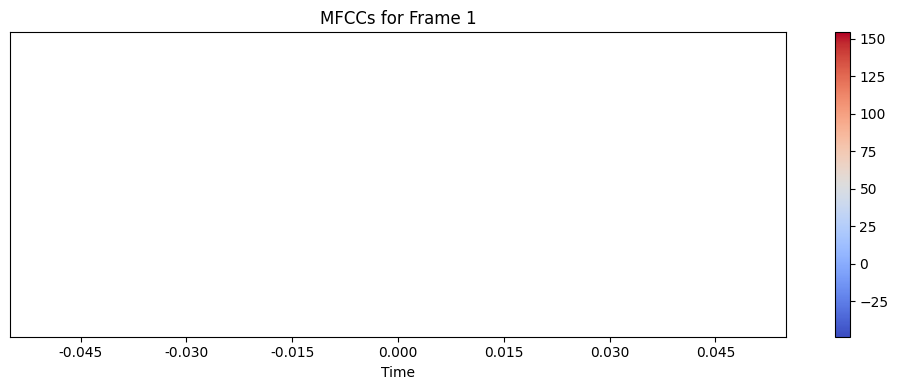

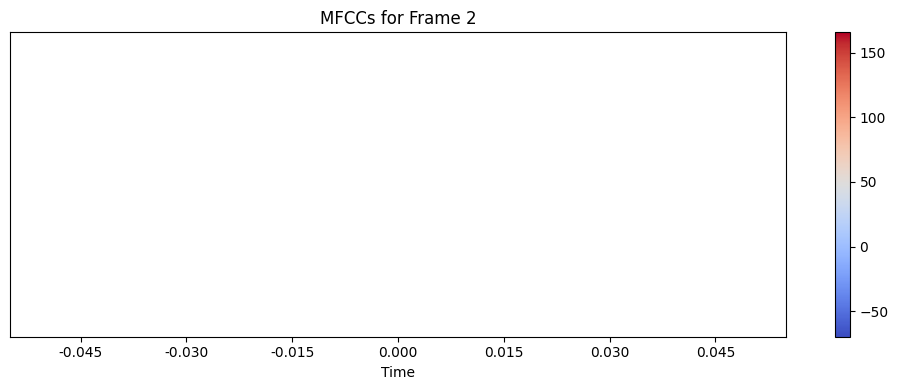

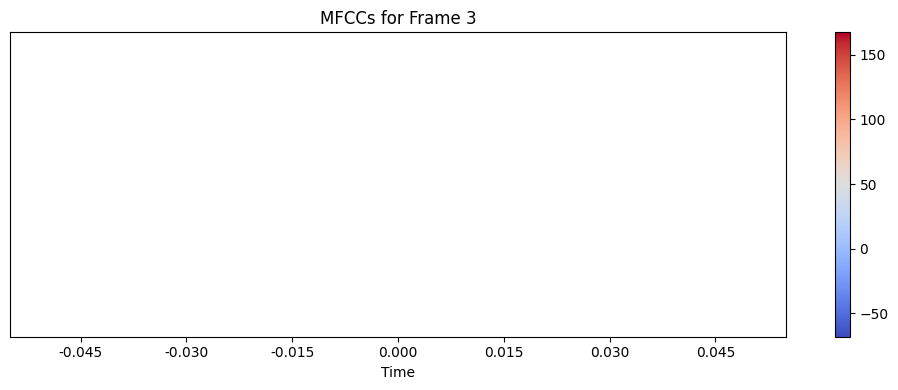

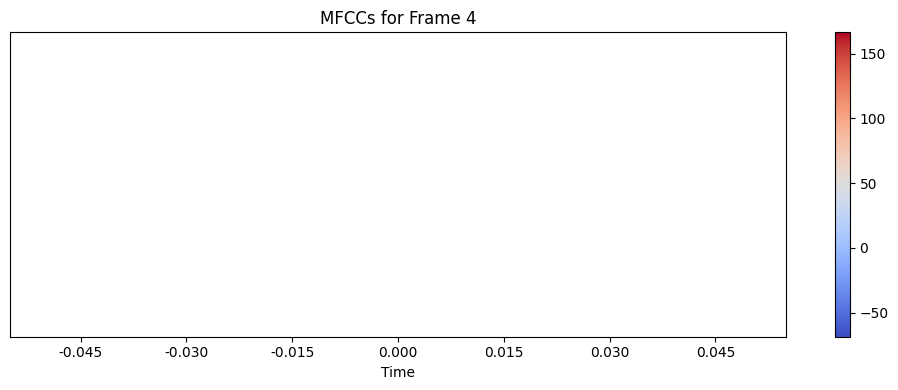

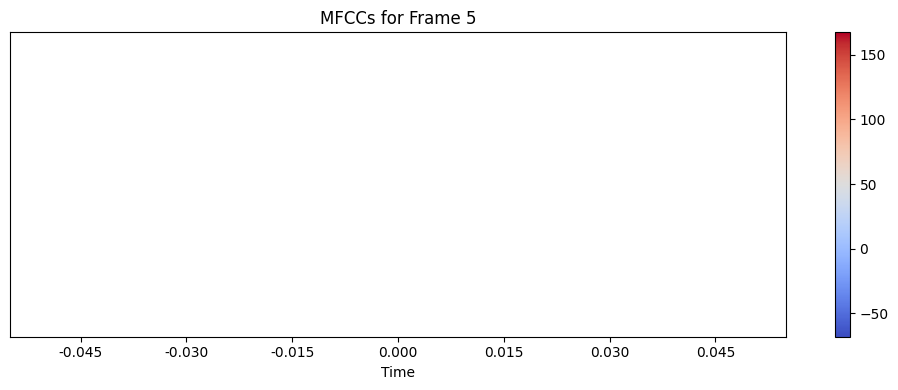

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

def visualize_mfccs(mfccs, title="MFCCs"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Assuming 'mfccs_array' is your NumPy array of MFCCs
# Visualize the first few MFCCs
for i in range(5):  # Adjust the range to visualize more or fewer MFCCs
    visualize_mfccs(mfccs_array[i], title=f"MFCCs for Frame {i+1}")

In [ ]:
print(mfccs_array.shape)
print(mfccs_array[0])  # Print the first MFCC

(4673, 13, 1)
[[154.27261659]
 [-26.69654566]
 [-48.6486788 ]
 [  8.98621607]
 [  0.45220646]
 [ 21.31141314]
 [  1.98320226]
 [-28.76126889]
 [ -8.02076529]
 [ 12.41161837]
 [  3.90716267]
 [-13.94731838]
 [-12.33508658]]


In [ ]:
print(np.isnan(mfccs_array).any())

False


Testing

In [ ]:
import os
import cv2

def extract_frames(video_path, output_folder, frame_interval=25):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(0, frame_count, frame_interval):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame_filename = os.path.join(output_folder, f"{os.path.basename(video_path).split('.')[0]}_frame_{i}.jpg")
            cv2.imwrite(frame_filename, frame)
    cap.release()

# Path to 'Youtube-real' folder
youtube_real_dir = '/content/drive/MyDrive/Celeb-DF/YouTube-real'

# Output path for frames
youtube_real_frames_path = '/content/drive/MyDrive/Celeb-DF/Frames-YouTube-Real'

# Extract frames from videos in 'Youtube-real' folder
for video_file in os.listdir(youtube_real_dir):
    video_path = os.path.join(youtube_real_dir, video_file)
    extract_frames(video_path, youtube_real_frames_path)

print(f"Extracted frames saved to {youtube_real_frames_path}.")


In [ ]:
# Debugging steps within your script
# Ensure generator yields correct inputs
for inputs, labels in combined_gen:
    print(f"Shape of mfcc_data: {inputs[0].shape}")
    print(f"Shape of fft_data: {inputs[1].shape}")
    print(f"Shape of combined_images: {inputs[2].shape}")
    print(f"Shape of combined_labels: {labels.shape}")
    break  # Check the first batch only

# Check input layer definitions in your model
print(f"Shape expected by mfcc_input: {mfcc_input.shape}")
print(f"Shape expected by fft_input: {fft_input.shape}")
print(f"Shape expected by vit_input: {vit_input.shape}")

# Adjust input shapes if necessary


In [ ]:
for inputs, labels in combined_gen:
    mfcc_data, fft_data, combined_images = inputs
    print(f"Shape of mfcc_data: {mfcc_data.shape}")
    print(f"Shape of fft_data: {fft_data.shape}")
    print(f"Shape of combined_images: {combined_images.shape}")
    print(f"Shape of combined_labels: {labels.shape}")
    break  # Print the first batch only for inspection

mfcc_input = tf.keras.layers.Input(shape=(13, 130), name='mfcc_input')
fft_input = tf.keras.layers.Input(shape=(130,), name='fft_input')
vit_input = tf.keras.layers.Input(shape=(128, 128, 3), name='vit_input')

# Example convolutional layers
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(vit_input)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(conv1)
conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(conv2)

# Apply Global Average Pooling
gap = tf.keras.layers.GlobalAveragePooling2D()(conv3)

# Example dense layers
dense1 = tf.keras.layers.Dense(256, activation='relu')(gap)
dense2 = tf.keras.layers.Dense(2, activation='softmax', name='output')(dense1)

# Define the model with inputs and outputs
model = tf.keras.models.Model(inputs=[mfcc_input, fft_input, vit_input], outputs=dense2)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define paths to your zip files
real_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Real-20240626T130257Z-001.zip'
fake_zip_path = '/content/drive/MyDrive/Celeb-DF/Frames-Fake-20240626T130258Z-001.zip'

# Unzip the files (assuming they are already unzipped)
!unzip -q -o '{real_zip_path}' -d '/content/Frames-Real'
!unzip -q -o '{fake_zip_path}' -d '/content/Frames-Fake'

# --- Data Generators ---
datagen = ImageDataGenerator(rescale=1./255)

# Define batch size for generators
batch_size = 24

real_generator = datagen.flow_from_directory(
    directory='/content/Frames-Real',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

fake_generator = datagen.flow_from_directory(
    directory='/content/Frames-Fake',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

def combined_generator(real_gen, fake_gen):
    while True:
        # Get batches from both generators simultaneously
        real_data, real_labels = next(real_gen)
        fake_data, fake_labels = next(fake_gen)

        # Ensure both batches have the same batch size
        min_batch_size = min(len(real_data), len(fake_data))
        real_data = real_data[:min_batch_size]
        real_labels = real_labels[:min_batch_size]
        fake_data = fake_data[:min_batch_size]
        fake_labels = fake_labels[:min_batch_size]

        # Combine batches
        combined_images = np.concatenate((real_data, fake_data), axis=0)
        combined_labels = np.concatenate((real_labels, fake_labels), axis=0)

        # Shuffle combined batch
        combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)

        # Generate dummy data for MFCC and FFT (replace with actual data)
        batch_size = combined_images.shape[0]
        mfcc_data = np.zeros((batch_size, 13, 130))  # Dummy MFCC data
        fft_data = np.zeros((batch_size, 130))       # Dummy FFT data

        # Convert labels to one-hot encoding
        combined_labels = tf.keras.utils.to_categorical(combined_labels, num_classes=2)

        # Print shapes for debugging
        print(f"Shape of mfcc_data: {mfcc_data.shape}")
        print(f"Shape of fft_data: {fft_data.shape}")
        print(f"Shape of combined_images: {combined_images.shape}")
        print(f"Shape of combined_labels: {combined_labels.shape}")

        yield [mfcc_data, fft_data, combined_images], combined_labels

# Combined generator
combined_gen = combined_generator(real_generator, fake_generator)

# Check a single batch from the generator
inputs, labels = next(combined_gen)

# Print shapes of inputs and labels for the first batch
print(f"Shape of inputs: {inputs[0].shape}, {inputs[1].shape}, {inputs[2].shape}")
print(f"Shape of labels: {labels.shape}")
